In [1]:
%config IPCompleter.greedy = True

In [2]:
import torch
import torchvision 
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim

from skimage import io, transform
from PIL import Image 
import matplotlib.pyplot as plt 
import numpy as np 
from glob import glob
import re
import time
import copy

In [3]:
device = torch.device('cuda:0')

In [4]:
def open_image(file):
    img = Image.open(file)
    img = img.convert('RGB')
    return img

In [5]:
pattern = re.compile(r'([^/]+)_\d+.jpg$')
files = glob('./pets/images/*.jpg')

classes = set()
labels = [] 
data = [] 

for f in files:
    img = open_image(f)
    data.append(img)
    
    res = pattern.search(f)
    name = res.group(1)
    classes.add(name)
    labels.append(name)

In [6]:
idx = {cls:idx for (idx, cls) in enumerate(classes)}
labels = torch.Tensor(list(map(lambda x: idx[x], labels))).long()

data = list(zip(data, labels))

In [7]:
class PetsDataSet(Dataset):
    def __init__(self, data, transform = None):
        
        self.data = data 
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return(image, label)
    
    def __len__(self):
        return len(self.data)
    

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
full_dataset = PetsDataSet(data, transform)
train_length = np.floor(len(full_dataset)*0.8).astype(int).item()
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_length, len(full_dataset)-train_length])
train_dl = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = True, num_workers = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


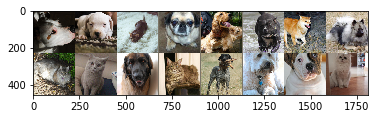

In [11]:
def show_img(img):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    plt.imshow(img)
    plt.show()

trainiter = iter(train_dl)
img, label = next(trainiter)

show_img(torchvision.utils.make_grid(img[:16, :, :, :]))

In [42]:
def train(epochs, optimizer, model):
    for epoch in range(epochs):
        running_loss = 0
        n_correct = 0
        
        # use dropouts and batchnorms
        model.train()
        for batch in train_dl:
            inputs, labels = batch
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dl)
        
        n_val_correct = 0
        val_loss = 0
        
        # disable batchnorm and dropouts
        model.eval()
        # don't calculate gradient
        with torch.no_grad():
            for batch in test_dl:
                inputs, labels = batch
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                val_loss = criterion(outputs, labels).item()
                   
            
        print('Epoch %s: Train Loss: %s, Validation Loss: %s' 
              % (epoch, train_loss, val_loss))
        
     

In [43]:
model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

In [44]:
model_trained = train(10, optimizer, model)

Epoch 0: Train Loss: 3.663546936486357, Validation Loss: 3.6036789417266846
Epoch 1: Train Loss: 3.665723828859227, Validation Loss: 3.644937753677368
Epoch 2: Train Loss: 3.6656142178402153, Validation Loss: 3.782989501953125


KeyboardInterrupt: 